Assignment 4 for ATM 523 Fall 2022
Written by Katie Straus


1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and precipitation anomalies from Jan 1979-Dec 2021 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The land sea mask is available here: https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc

In [ ]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import xarray as xr
import netCDF4 as nc

import dask
from dask.distributed import Client, progress
client = Client()  # set up local cluster on your laptop
client


#not yet used
import statsmodels as sm
import tensorflow as tf
import sklearn 
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
#from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller



In [2]:

import dask
from dask.distributed import Client, progress
client = Client()  # set up local cluster on your laptop
client

/Users/catherinestraus/opt/anaconda3/envs/523HW4/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50942 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:50942/status,
Dashboard: http://127.0.0.1:50942/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50943,Workers: 4
Dashboard: http://127.0.0.1:50942/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:50955,Total threads: 2
Dashboard: http://127.0.0.1:50958/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:50947,


First retrieve data from NCAR UCAR reanalysis data is in 1/4 lat and lon, so take every 4th to save on space and time. Use dask to retrieve data in file list faster with parallel computing. 

go to RDA NCAR and go to ERA 5 monthly mean data for 0.25 lat/lon, 
Access Data--> TDS access for the chosen netcdf4 data-->1979-->sstk-->OpenDAP--> copy url

In [3]:
#Use pandas to create list of files to pull from NCAR UCAR

SST_base_url='https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
PPT_base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
SST_base_url2='/e5.moda.an.sfc.128_034_sstk.ll025sc.'
PPT_base_url2 = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
base_url4 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

SST_file_list =[]
PPT_file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    SST_single_file=(SST_base_url+year+SST_base_url2+month+'_'+month2+base_url4)
    SST_file_list.append(SST_single_file)
    PPT_single_file=(PPT_base_url+year+PPT_base_url2+month+'_'+month2+base_url4)
    PPT_file_list.append(PPT_single_file)


Use dask and xarray open_mfdataset() to read in data from online files. Each file contains data for the year (12 months) for all Lat-Lon at 1/4 resolution

"Calculate anomolies and save to a dataset array"
THIS IS STATISTICALLY INCORRECT, YOU SHOULD DESEASONALIZE, DETREND, AND STANDARDIZE AND THEN FIND THE ANOMALIES. ANY ANOMALOUS FOUND BEFORE HAND WOULD BE SKEWED DUE TO INHERENT FEATURES OF THE DATA



In [4]:
min_lat = -65 #degrees North
max_lat = 65 
min_lon = 120 #degrees East
max_lon = 360-60
lat_list = np.arange( min_lat,max_lat)
lon_list = np.arange( min_lon,max_lon)

SST_data = xr.open_mfdataset(SST_file_list, parallel=True)
PPT_data = xr.open_mfdataset(PPT_file_list, parallel= True)

sst_sub = SST_data['SSTK'].sel(latitude= slice(max_lat, min_lat, 4),longitude= slice(min_lon, max_lon, 4))
ppt_sub = PPT_data['TP'].sel(latitude= slice(max_lat, min_lat,  4),longitude= slice(min_lon, max_lon, 4))

sst_sub_data=sst_sub.compute()
ppt_sub_data=ppt_sub.compute()

#create dataset
Pacific_dataset=xr.Dataset(data_vars=dict(SST=(['time','latitude','longitude'], sst_sub_data.data, {'Units':'K', 'Long_Name':'sea surface temperatures from 1979-2021'}),
                                          PPT=(['time','latitude', 'longitude'], ppt_sub_data.data, {'Units':'m', 'Long_Name':'Total accumulate precipitation from 1979-2021'})),
                coords=dict(latitude=(['latitude'], sst_sub_data.latitude.data),
                            longitude=(['longitude'], sst_sub_data.longitude.data),
                            time=sst_sub_data.time.data,))


#save to local computer
Pacific_dataset.to_netcdf('/Users/catherinestraus/opt/anaconda3/envs/523HW4/hw4_sst_ppt_dataset.nc')

In [93]:
#create dataset
Pacific_dataset=xr.Dataset(data_vars=dict(SST=(['time','latitude','longitude'], sst_sub_data.data, {'Units':'K', 'Long_Name':'sea surface temperatures from 1979-2021'}),
                                          PPT=(['time','latitude', 'longitude'], ppt_sub_data.data, {'Units':'m', 'Long_Name':'Total accumulate precipitation from 1979-2021'})),
                coords=dict(latitude=(['latitude'], sst_sub_data.latitude.data),
                            longitude=(['longitude'], sst_sub_data.longitude.data),
                            time=sst_sub_data.time.data,))


#save to local computer
Pacific_dataset.to_netcdf('/Users/catherinestraus/opt/anaconda3/envs/523HW4/hw4_sst_ppt_dataset.nc')

2)  From the dataset shown in 1, deseasonalize (remove the mean monthly anomaly from the annual mean from each point), detrend, and standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)
   
   Hints: [Monthly data analysis &#8212; PyCLIM_101 0.2 documentation](https://climate.usu.edu/people/yoshi/pyclm101/monthly.html)

In [2]:
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import xarray as xr
import netCDF4 as nc

import dask
from dask.distributed import Client, progress
client = Client()  # set up local cluster on your laptop
client

distributed.diskutils - INFO - Found stale lock file and directory '/Users/catherinestraus/opt/anaconda3/envs/523HW4/dask-worker-space/worker-xat5errv', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/catherinestraus/opt/anaconda3/envs/523HW4/dask-worker-space/worker-1122fuk0', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/catherinestraus/opt/anaconda3/envs/523HW4/dask-worker-space/worker-2dbg_mjn', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/catherinestraus/opt/anaconda3/envs/523HW4/dask-worker-space/worker-3j5xvtc2', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/catherinestraus/opt/anaconda3/envs/523HW4/dask-worker-space/worker-mdfdu4rp', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/catherinestraus/opt/anaconda3/envs/523HW4/dask-worker-space/worker-troe_pj1', purging
distributed.diskutils - INFO - Fou

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54563,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:54575,Total threads: 2
Dashboard: http://127.0.0.1:54580/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:54569,


In [3]:
#read in dataset on local computer

Pacific_read=xr.open_dataset('/Users/catherinestraus/opt/anaconda3/envs/523HW4/hw4_sst_ppt_dataset.nc')

#Pacific_sst_annual_mean=Pacific_read['SST'].mean()


Pacific_sst_monthly_mean=Pacific_read['SST'].groupby('time.month').mean('time')

#deseasonalize
Pacific_sst_deseasonalized=Pacific_read['SST'].groupby('time.month')-Pacific_sst_monthly_mean

#detrend
def detrend_dim(D, dim, deg=1):
    p=D.polyfit(dim=dim, deg=deg)
    fit=xr.polyval(D[dim], p.polyfit_coefficients)
    return D-fit

Pacific_sst_detrended_deseasonalized=detrend_dim(Pacific_sst_deseasonalized, 'time')

#standardize
Pacific_sst_DDS=(Pacific_sst_detrended_deseasonalized-Pacific_sst_detrended_deseasonalized.mean('time')/Pacific_sst_detrended_deseasonalized.std('time'))


In [4]:
Pacific_sst_DDS

<xarray.DataArray (time: 516, latitude: 131, longitude: 181)>
array([[[            nan,             nan,             nan, ...,
          3.57638500e-01,  3.42774913e-01,  3.13226414e-01],
        [            nan,             nan,             nan, ...,
          3.60173378e-01,  3.45484948e-01,  5.42518318e-01],
        [            nan,             nan,             nan, ...,
          3.45746966e-01,  7.09745663e-01,  1.45693899e+00],
        ...,
        [-1.79620631e-01, -2.46694515e-01, -3.52522390e-01, ...,
         -1.71739795e-01,  3.44646978e-02,  2.64244196e-02],
        [-4.38271196e-01, -4.57479927e-01, -5.29775856e-01, ...,
         -1.73027695e-01, -2.73703631e-03,             nan],
        [-7.51673342e-01, -7.07834366e-01, -6.99995918e-01, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
          3.56224363e-01,  3.43425720e-01,  3.29370981e-01],
        [            nan,             nan,             nan, ...,
          3.60815252e-01,  3.55268907e-01,  4.74647187e-01],
        [            nan,             nan,             nan, ...,
          3.41396804e-01,  7.29626754e-01,  1.52845670e+00],
...
        [ 4.84191005e-02,  1.96796757e-01,  2.91120194e-01, ...,
          5.02508945e-01,  4.89273203e-01,  3.12528778e-01],
        [-1.58994305e-01, -1.98397191e-01, -2.07062150e-01, ...,
          3.47804514e-01,  4.13092723e-01,             nan],
        [-8.13139248e-02, -1.02626951e-01, -1.05249885e-01, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -2.93875556e-01, -2.48667029e-01, -2.99170190e-01],
        [            nan,             nan,             nan, ...,
         -2.83646082e-01, -2.92226842e-01, -1.06253033e-01],
        [            nan,             nan,             nan, ...,
         -2.59341117e-01, -3.72155495e-02,  1.38443856e-01],
        ...,
        [ 9.95336391e-02,  1.24434068e-01,  5.70687963e-02, ...,
          7.12539758e-02, -4.45523633e-04, -2.68205691e-01],
        [-4.15207744e-02, -3.80542589e-02,  3.98384389e-02, ...,
          1.40442640e-01,  5.79590176e-02,             nan],
        [-2.24750560e-01, -2.37781525e-01, -2.39953472e-01, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

3) Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.

In [5]:
import cartopy.crs as ccrs  #use python=3.9.13 for cartopy to work
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof


import warnings
warnings.filterwarnings('ignore')

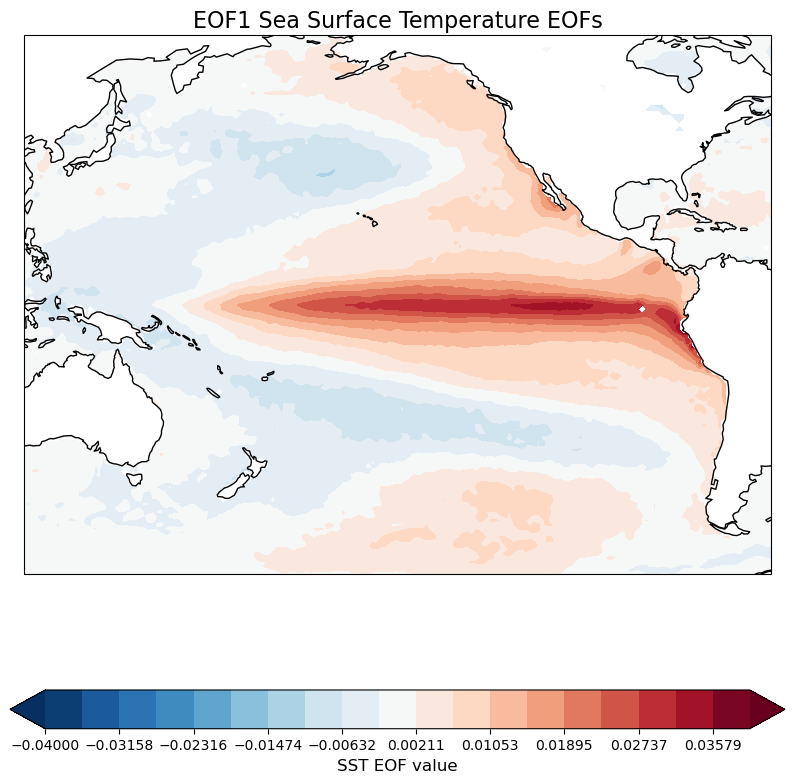

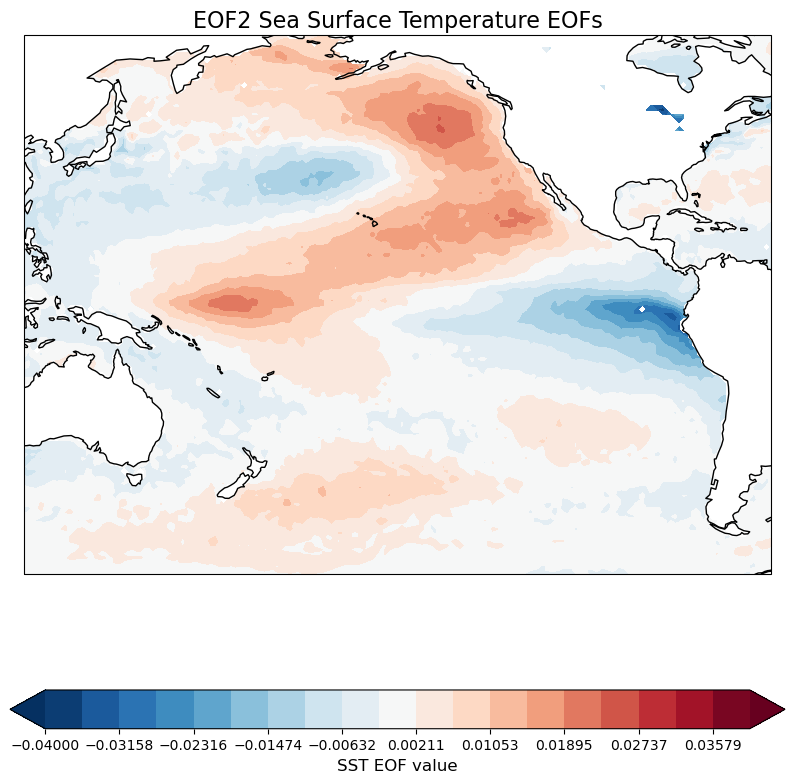

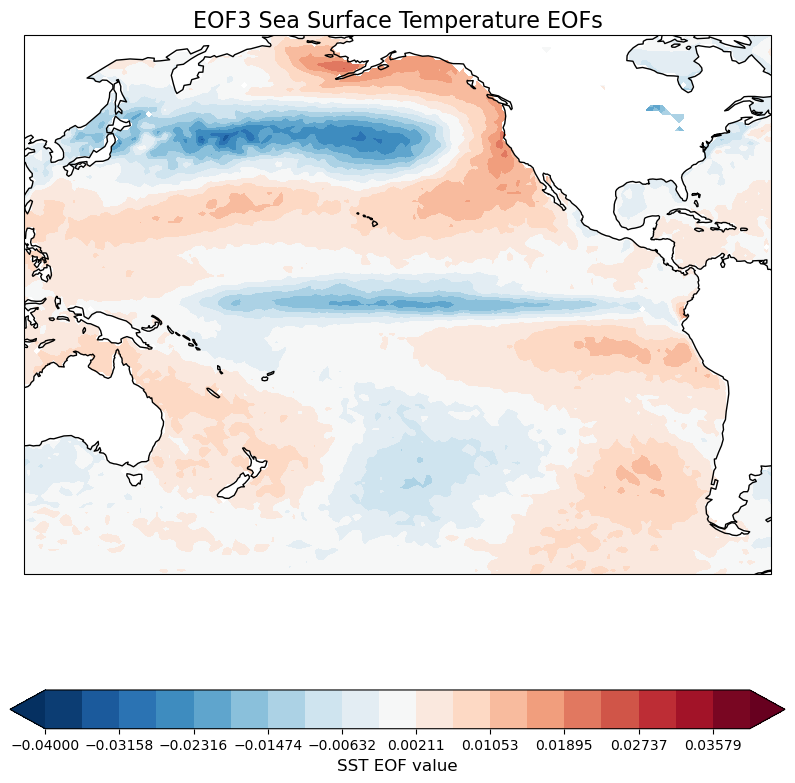

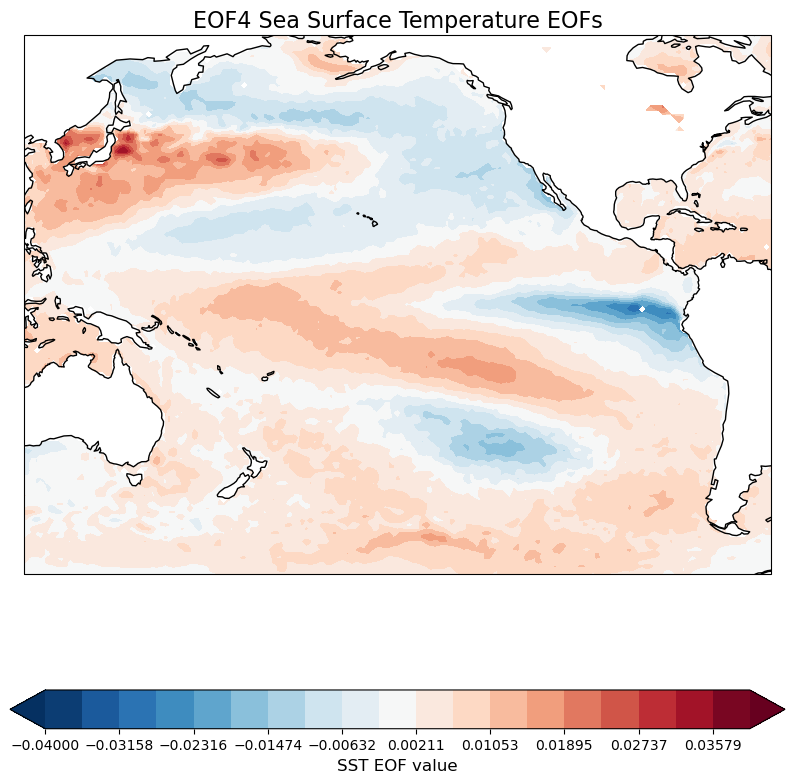

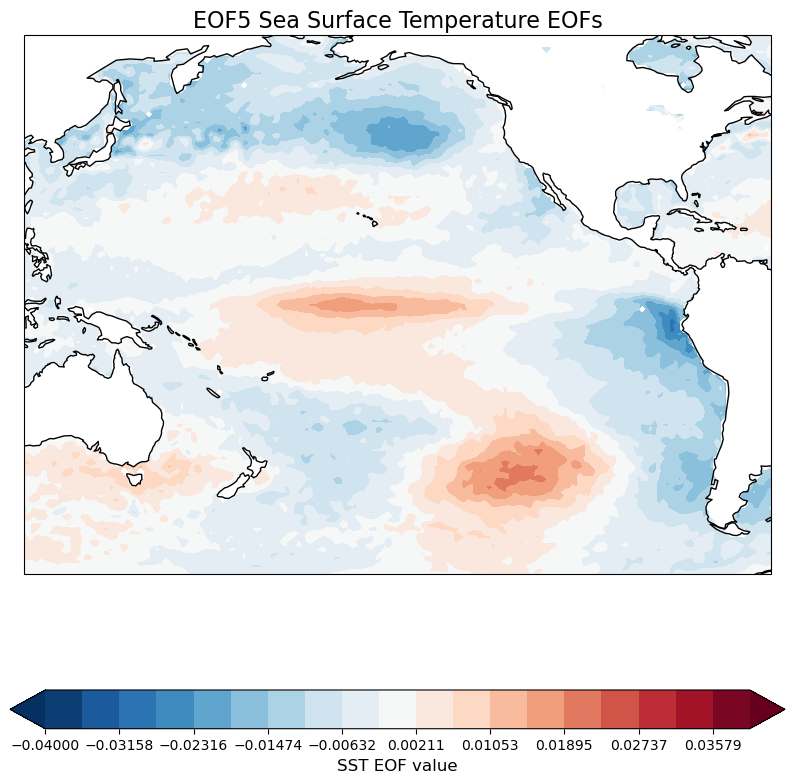

In [11]:

#weight geographic location by latitude as latitude has a greater significance on meteorological values than longitude
coslat = np.cos(np.deg2rad(Pacific_sst_DDS.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

#create EOF solver for analysis
sst_solver = Eof(Pacific_sst_DDS, weights=wgts)

#plot first 5 eofs
first_five_eofs=sst_solver.eofs(neofs=5)

for m in range(len(first_five_eofs)):
    clevs = np.linspace(-0.04, 0.04, 20)
    fig=plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
    fill = ax.contourf(first_five_eofs.longitude.values, first_five_eofs.latitude.values, first_five_eofs[m].data, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree(), extend='both')
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    cb = plt.colorbar(fill, orientation='horizontal')
    cb.set_label('SST EOF value', fontsize=12)
    ax.set_title('EOF%s Sea Surface Temperature EOFs' % (str(m+1)), fontsize=16)

    plt.show()


4) Plot the percent of variance explained by the first 10 EOFs.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


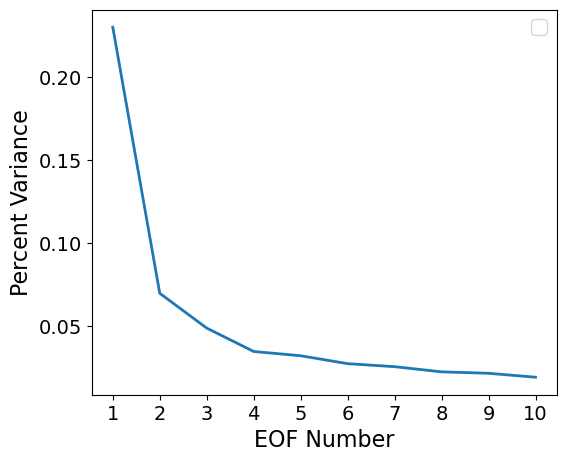

In [12]:
#retrieve variance fractions for first 10 eofs
sst_eof_variance=sst_solver.varianceFraction(neigs=10)

#plot
plt.figure(figsize=(6,5))
plt.plot(sst_eof_variance.mode+1,sst_eof_variance.data, linewidth=2)
plt.ylabel('Percent Variance', fontsize = 16)
plt.xlabel('EOF Number', fontsize = 16)

plt.tick_params(labelsize = 14)

plt.xticks(np.arange(1, 11, 1))
plt.legend(fontsize = 14)
plt.show()


5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series and the "observed" SST time series.

In [ ]:
reconstruction = sst_solver.reconstructedField(5)



*According to recent discussions on Slack and Git, an update has created a bug for the compatability between the EOFs code and xarray. The merge request from some other coders has been made but currently the merge itself has not been made, so some functions, such as .recontructedFiedl() are temporarily broken.

In [ ]:
#if the code above worked
pearson_cor_SST = xr.corr(reconstruction, Pacific_sst_DDS, dim ='time')

clevs = np.linspace(-1, 1, 40)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = ax.contourf(pearson_cor_SST.longitude.values, pearson_cor_SST.latitude.values, pearson_cor_SST.data, levels=clevs, cmap=plt.cm.RdBu_r,
                    add_colorbar=False, transform=ccrs.PlateCarree(), extend='both')
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('Correlation Coefficient', fontsize=12)
ax.set_title('Pearsons correlation between EOF reconstruction and Cleaned Data of Sea Surface Temperature',  fontsize=16)

6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean precipitation anomalies (don't mask these over land for the plot).  See anything interesting?


In [ ]:
#eof 1 for sst
eof1_sol_SST = Eof(Pacific_sst_DDS, weights=wgts)
#reconstruct based on eof
reconstruction_1 = eof1_sol_SST.reconstructedField(1)

#obtain ppt data, detrend, deseasonalize, and standardize

Pacific_ppt_monthly_mean=Pacific_read['PPT'].groupby('time.month').mean('time')
#deseasonalize
Pacific_ppt_deseasonalized=Pacific_read['PPT'].groupby('time.month')-Pacific_ppt_monthly_mean
#detrend
Pacific_ppt_detrended_deseasonalized=detrend_dim(Pacific_ppt_deseasonalized, 'time')
#standardize
Pacific_ppt_DDS=(Pacific_ppt_detrended_deseasonalized-Pacific_ppt_detrended_deseasonalized.mean('time')/Pacific_ppt_detrended_deseasonalized.std('time'))

#compute pearsons corr between ssst eof1 and ppt
ssteof_ppt_pearsons_corr=xr.corr(reconstruction_1, Pacific_ppt_DDS, dim='time')

#plot corr between eof and ppt
clevs = np.linspace(-1, 1, 40)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = ax.contourf(ssteof_ppt_pearsons_corr.longitude.values, ssteof_ppt_pearsons_corr.latitude.values, ssteof_ppt_pearsons_corr.data, levels=clevs, cmap=plt.cm.RdBu_r,
                    add_colorbar=False, transform=ccrs.PlateCarree(), extend='both')
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('Correlation Coefficient', fontsize=12)
ax.set_title('Pearsons correlation between EOF1 reconstruction SST and Precipitation (DDS) Data',  fontsize=16)